In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision import datasets, transforms, models
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# set directory where datasets will be downloaded
os.environ['KAGGLEHUB_CACHE'] = '/Users/trentbellinger/Desktop/Stats 229/Final Project'

# download locally
path = kagglehub.dataset_download('pietrob92/wild-in-the-wild-image-linkage-dataset')
print(f"Dataset downloaded to: {path}")

In [ ]:
# Fourier transform (frequency of image)
def fft_transform(img_tensor):
    """
    img_tensor: (C, H, W), values in [0,1]
    returns: (C, H, W)
    """
    fft = torch.fft.fft2(img_tensor)
    fft = torch.fft.fftshift(fft)
    mag = torch.log(torch.abs(fft) + 1e-8)
    return mag

In [ ]:
# check whether a file is an image
def is_image_file(path):
    return path.lower().endswith(IMG_EXTENSIONS)

In [ ]:
# analogous to torch class ImageFilter but with both frequency and RGB information
class DualImageFolder(datasets.ImageFolder):
    def __init__(self, root, rgb_transform=None, freq_transform=None):
        super().__init__(
            root,
            transform=None,
            is_valid_file=is_image_file
        )
        self.rgb_transform = rgb_transform
        self.freq_transform = freq_transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert("RGB")

        rgb = self.rgb_transform(img)
        freq = fft_transform(rgb)
        if self.freq_transform:
            freq = self.freq_transform(freq)

        return rgb, freq, label

In [ ]:
# resize, randomly flip, normalize rgb information
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# normalize frequency information
freq_transform = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0],
                         std=[1.0, 1.0, 1.0])
])

In [ ]:
# create dataset (root is whatever folder you have all the data in)
dataset = DualImageFolder(
    root="Data/Closed_Set",
    rgb_transform=rgb_transform,
    freq_transform=freq_transform
)

labels = [label for _, label in dataset.samples]
labels = np.array(labels)
indices = np.arange(len(labels))

# get train, val, test indices
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# make sure the datasets are the correct size and stratified
def count_labels(indices, labels):
    return Counter(labels[indices])
print("Train:", count_labels(train_idx, labels))
print("Val:  ", count_labels(val_idx, labels))
print("Test: ", count_labels(test_idx, labels))

Train: Counter({8: 700, 2: 700, 0: 700, 5: 700, 9: 700, 6: 700, 4: 700, 1: 700, 7: 700, 3: 700})
Val:   Counter({5: 150, 4: 150, 2: 150, 6: 150, 8: 150, 3: 150, 0: 150, 1: 150, 9: 150, 7: 150})
Test:  Counter({2: 150, 4: 150, 1: 150, 5: 150, 8: 150, 7: 150, 0: 150, 9: 150, 6: 150, 3: 150})


In [ ]:
# define our dual flow model, use resnet18 for both streams (will test different models too)
class DualStreamNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # default weights for the RGB model
        self.rgb_net = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # we will learn the weights for the frequency model
        self.freq_net = resnet18(weights=None)

        rgb_features = self.rgb_net.fc.in_features
        freq_features = self.freq_net.fc.in_features

        self.rgb_net.fc = nn.Identity()
        self.freq_net.fc = nn.Identity()

        # add a linear layer (ReLU activation) and dropout (to reduce overfitting)
        # can change process here
        self.classifier = nn.Sequential(
            nn.Linear(rgb_features + freq_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    # forward pass for our model
    def forward(self, rgb, freq):
        f_rgb = self.rgb_net(rgb)
        f_freq = self.freq_net(freq)
        return self.classifier(torch.cat([f_rgb, f_freq], dim=1))

In [ ]:
# get loss and accuracy for our model
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for rgb, freq, labels in loader:
            rgb = rgb.to(device)
            freq = freq.to(device)
            labels = labels.to(device)

            outputs = model(rgb, freq)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    error = 1.0 - accuracy

    return avg_loss, accuracy, error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualStreamNet(num_classes=10).to(device)

# use cross-entropy loss and Adam optimizer (learning rate 0.0001)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# define a class that will allow us to stop training early if performance doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        # improvement
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return True
        # no improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
            return False

In [ ]:
max_epochs = 50
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

best_model_path = "best_model.pt"

# train the model
for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    # go through each batch of our data
    for rgb, freq, labels in train_loader:
        rgb = rgb.to(device)
        freq = freq.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(rgb, freq)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

    # average training loss
    train_loss /= len(train_loader.dataset)

    val_loss, val_acc, val_err = evaluate(
        model, val_loader, criterion, device
    )
    
    # see if we improved on the previous epoch
    improved = early_stopping.step(val_loss)
    if improved:
        torch.save(model.state_dict(), best_model_path)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    if early_stopping.should_stop:
        print(
            f"\nEarly stopping triggered "
            f"(no val loss improvement for {early_stopping.patience} epochs)."
        )
        break

Epoch 01 | Train Loss: 0.7609 | Val Loss: 0.4087 | Val Acc: 0.8653
Epoch 02 | Train Loss: 0.1156 | Val Loss: 0.1218 | Val Acc: 0.9633
Epoch 03 | Train Loss: 0.0569 | Val Loss: 0.0834 | Val Acc: 0.9693
Epoch 04 | Train Loss: 0.0409 | Val Loss: 0.0847 | Val Acc: 0.9733
Epoch 05 | Train Loss: 0.0313 | Val Loss: 0.1086 | Val Acc: 0.9680
Epoch 06 | Train Loss: 0.0278 | Val Loss: 0.0999 | Val Acc: 0.9680
Epoch 07 | Train Loss: 0.0332 | Val Loss: 0.0872 | Val Acc: 0.9733
Epoch 08 | Train Loss: 0.0333 | Val Loss: 0.0520 | Val Acc: 0.9840
Epoch 09 | Train Loss: 0.0329 | Val Loss: 0.0593 | Val Acc: 0.9847
Epoch 10 | Train Loss: 0.0268 | Val Loss: 0.1167 | Val Acc: 0.9633
Epoch 11 | Train Loss: 0.0358 | Val Loss: 0.0870 | Val Acc: 0.9727
Epoch 12 | Train Loss: 0.0142 | Val Loss: 0.0507 | Val Acc: 0.9853
Epoch 13 | Train Loss: 0.0104 | Val Loss: 0.1272 | Val Acc: 0.9640
Epoch 14 | Train Loss: 0.0109 | Val Loss: 0.1151 | Val Acc: 0.9707
Epoch 15 | Train Loss: 0.0155 | Val Loss: 0.0546 | Val Acc: 0.

In [ ]:
# get test data results
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc, test_err = evaluate(
    model, test_loader, criterion, device
)

print("\n===== FINAL TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


===== FINAL TEST RESULTS =====
Test Loss: 0.0476
Test Accuracy: 0.9813


In [ ]:
# get model prediction for each image
def get_test_predictions(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for rgb, freq, labels in loader:
            rgb = rgb.to(device)
            freq = freq.to(device)

            outputs = model(rgb, freq)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

class_names = dataset.classes

y_true, y_pred = get_test_predictions(model, test_loader, device)

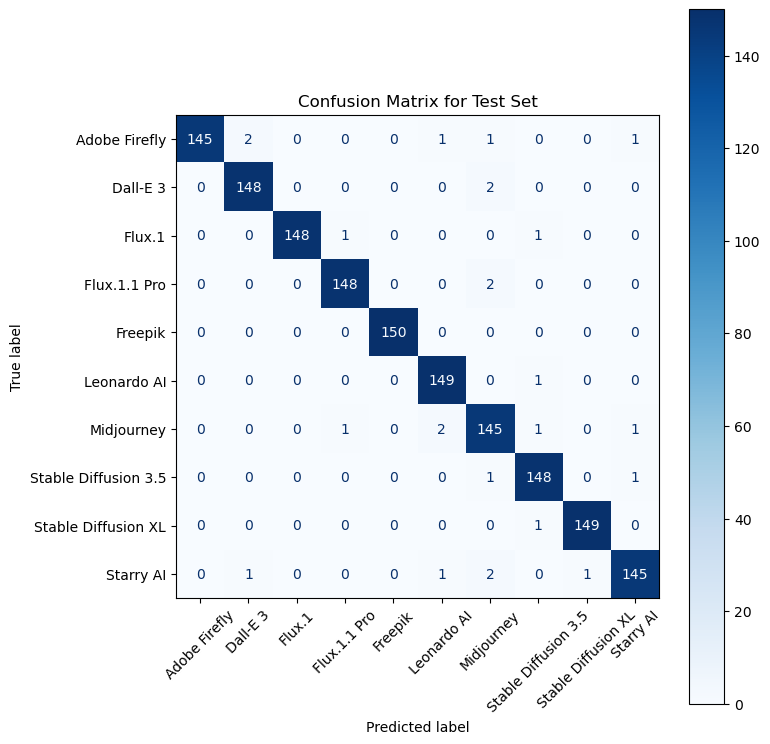

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix for Test Set")
plt.tight_layout()
plt.show()

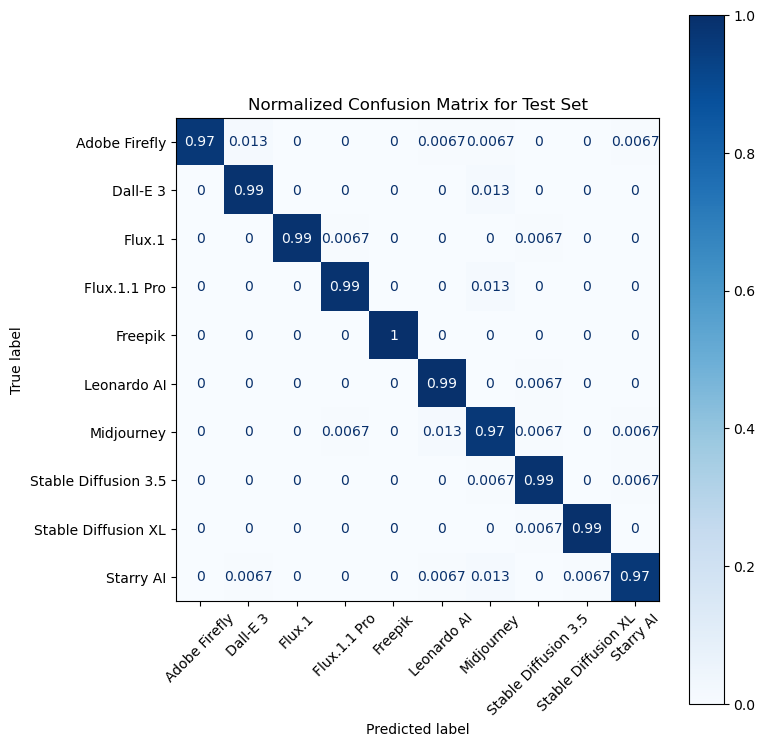

In [ ]:
# normalized confusion matrix
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")

disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 8))
disp_norm.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("Normalized Confusion Matrix for Test Set")
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import pandas as pd

seed = np.random.randint(0, 2**32 - 1)
np.random.seed(seed)

numbers = np.arange(1, 235)
np.random.shuffle(numbers)

teams = np.array(
    ["Breakers"] * 36 +
    ["Inferno"] * 33 +
    ["Snow Crabs"] * 30 + 
    ["Churros"] * 27 +
    ["Kiwis"] * 24 +
    ["Preds"] * 21 + 
    ["Hogs"] * 18 +
    ["Cyclones"] * 15 +
    ["Kodiaks"] * 12 + 
    ["Spuds"] * 9 +
    ["Turtles"] * 6 +
    ["Lemurs"] * 3
)

df = pd.DataFrame({"Team":teams, "Number":numbers})

df_team_sort = (
    df.assign(team_freq=df["Team"].map(df["Team"].value_counts()))
      .sort_values(["team_freq", "Team", "Number"], ascending=[False, True, True])
      .drop(columns="team_freq")
).reset_index(drop = True)

df_number_sort = df.sort_values("Number", ascending = True).reset_index(drop = True)

df_list = (
    df.groupby("Team")["Number"]
      .apply(list)
      .reset_index()
)

pd.set_option("display.max_colwidth", None)
display(df_list)

,Team,Number
0,Breakers,"[215, 62, 58, 228, 95, 209, 213, 129, 47, 70, 60, 91, 76, 7, 151, 48, 149, 67, 208, 97, 56, 176, 6, 138, 29, 13, 44, 166, 37, 141, 194, 71, 188, 16, 137, 225]"
1,Churros,"[78, 113, 204, 115, 100, 17, 59, 147, 189, 122, 83, 28, 161, 49, 170, 46, 72, 144, 190, 226, 77, 199, 118, 114, 159, 57, 34]"
2,Cyclones,"[92, 116, 88, 65, 205, 96, 4, 1, 30, 68, 86, 39, 21, 156, 109]"
3,Hogs,"[197, 14, 167, 53, 227, 105, 179, 218, 79, 127, 221, 111, 117, 33, 230, 5, 9, 74]"
4,Inferno,"[192, 206, 178, 145, 36, 107, 123, 181, 202, 38, 203, 229, 25, 224, 198, 154, 99, 232, 143, 124, 93, 234, 54, 69, 87, 183, 120, 75, 121, 31, 35, 187, 142]"
5,Kiwis,"[73, 164, 148, 19, 175, 102, 50, 193, 94, 2, 153, 63, 61, 131, 110, 173, 186, 155, 191, 125, 43, 168, 108, 89]"
6,Kodiaks,"[126, 182, 233, 90, 172, 157, 24, 180, 119, 171, 165, 134]"
7,Lemurs,"[146, 130, 136]"
8,Preds,"[201, 66, 163, 26, 80, 211, 22, 103, 139, 135, 184, 132, 55, 220, 140, 10, 112, 128, 27, 104, 216]"
9,Snow Crabs,"[52, 18, 32, 81, 101, 185, 160, 214, 82, 207, 106, 42, 12, 8, 174, 169, 51, 85, 212, 40, 177, 162, 45, 98, 196, 133, 64, 222, 219, 23]"


In [ ]:
numbers = [1, 7, 14, 26, 29, 34, 37, 42, 46, 47, 55, 70, 73, 74, 77, 80, 84, 
           94, 96, 99, 103, 105, 117, 118, 132, 134, 136, 141, 143, 151, 156, 
           174, 176, 177, 191, 229, 11, 13, 28, 30, 35, 50, 64, 75, 79, 90, 97, 
           101, 112, 113, 119, 123, 125, 131, 133, 139, 142, 145, 155, 158, 161, 
           165, 170, 187, 190, 199, 203, 207, 212, 5, 20, 22, 31, 43, 48, 54, 61, 
           62, 67, 109, 116, 126, 148, 180, 182, 186, 188, 197, 198, 201, 202, 209, 
           216, 217, 221, 223, 228, 232, 233, 3, 4, 8, 10, 15, 21, 36, 41, 68, 83, 
           89, 91, 100, 110, 114, 149, 162, 163, 171, 175, 184, 194, 196, 214, 218, 
           219, 227, 16, 25, 27, 33, 38, 57, 78, 81, 87, 102, 122, 124, 129, 135, 
           137, 146, 153, 164, 169, 172, 178, 192, 213, 234, 9, 32, 45, 51, 52, 59, 
           65, 66, 72, 76, 95, 115, 140, 147, 157, 166, 168, 185, 206, 224, 230, 
           2, 6, 18, 19, 40, 71, 85, 93, 106, 111, 159, 160, 173, 189, 200, 204, 
           205, 211, 24, 53, 56, 63, 69, 88, 98, 104, 127, 144, 150, 179, 181, 195, 
           225, 23, 39, 58, 82, 107, 120, 121, 152, 167, 183, 208, 226, 92, 108, 130, 
           138, 193, 210, 215, 222, 231, 12, 17, 44, 49, 128, 154, 60, 86, 220]

len(numbers)

234

In [23]:
len(np.unique(numbers))

234